In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', 7)


## San Diego City Salaries

The dataset at hand includes a list of all San Diego city employee salaries for a particular year. This includes employee names and job titles, as well as the components of their total pay during the year 2017.

Dataset link : https://transparentcalifornia.com/salaries/san-diego/

In [2]:
salary_path = os.path.join('data', 'san-diego-2017.csv')
salaries = pd.read_csv(salary_path)
salaries.reset_index(drop=True)

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
0,David P Gerboth,Fire Battalion Chief,81917.0,172590.0,68870.00,21784.0,323377.0,NaN,345161.0,2017,NaN,San Diego,FT
1,Scott C Chadwick,Chief Operating Officer,255000.0,0.0,31164.00,49921.0,286164.0,NaN,336085.0,2017,NaN,San Diego,FT
2,Glen A Bartolome,Fire Captain,85904.0,120682.0,99408.00,26470.0,305994.0,NaN,332464.0,2017,NaN,San Diego,FT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,Stephen J Hill,Council Rep 2 A,0.0,0.0,8.00,0.0,8.0,NaN,8.0,2017,NaN,San Diego,PT
12491,Tania Serhan,Sr Mgmt Anlyst,0.0,0.0,8.00,0.0,8.0,NaN,8.0,2017,NaN,San Diego,PT
12492,Brian D Cassels,Police Officer,0.0,0.0,3.00,0.0,3.0,NaN,3.0,2017,NaN,San Diego,PT


### Basic description of employee pay

The table below contains a basic of description of employee pay. What does typical pay look like? 

In [3]:
salaries.describe().T

,count,mean,std,min,25%,50%,75%,max
Base Pay,12493.0,48843.853918,29377.449188,0.0,28888.0,49254.0,68952.0,255000.0
Overtime Pay,12493.0,6573.031858,15308.455700,-623.0,0.0,393.0,5408.0,196978.0
Benefits,12493.0,12853.013207,9199.780447,-29.0,5262.0,12483.0,18633.0,81633.0
...,...,...,...,...,...,...,...,...
Total Pay & Benefits,12493.0,77837.984231,49224.288964,3.0,46218.0,74289.0,109483.0,345161.0
Year,12493.0,2017.000000,0.000000,2017.0,2017.0,2017.0,2017.0,2017.0
Notes,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observations:
* What are the negative payments? Near zero salaries?
* Other pay column is not present
* Are the salaries in the 'max' column real?

### Empirical Distribution of Salaries
. Plotting the empirical distribution of salaries raises two observations:
* The distribution is 'bimodal' and is likely comprised of two distributions.
* The salaries have a skew to the right, which is typical for a quantity that can only be non-negative.

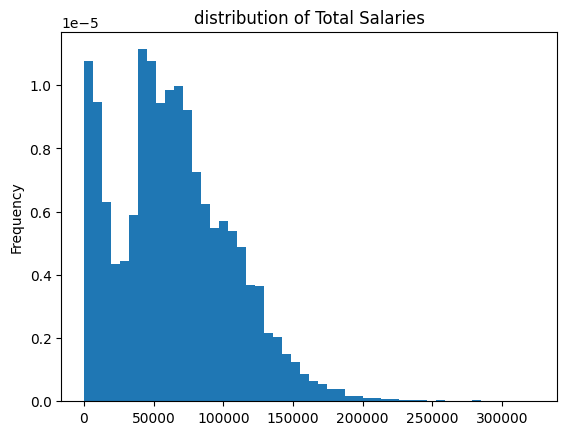

In [4]:
salaries['Total Pay'].plot(kind='hist', bins=50, density=True, title='distribution of Total Salaries');

A reasonable guess for the bimodal nature of the distribution of salaries is the employment status. One would expect salaries to vary significantly based on whether an employee works Part-time versus Full-time. Splitting the population up by job status reveals two distributions:
* The part-time jobs tend to have lower salaries, closer to 0,
* The full-time jobs tends to have salaries centered around 80,000 USD.

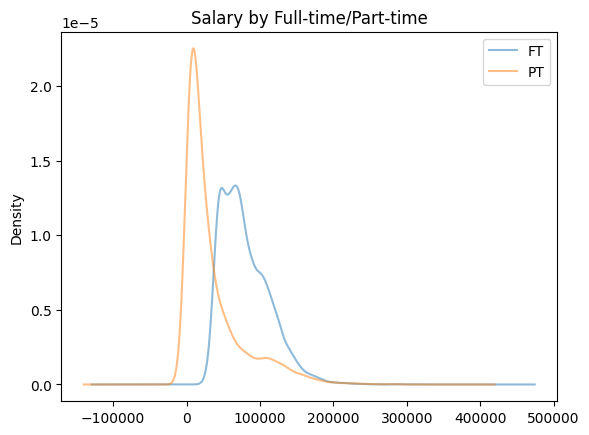

In [5]:
bystatus = salaries.groupby('Status')
bystatus['Total Pay'].plot(kind='kde', alpha=0.5, title='Salary by Full-time/Part-time')
plt.legend(bystatus.groups);

In [6]:
salaries = salaries[['Employee Name', 'Job Title', 'Total Pay', 'Status']].copy()

### Do women earn similar pay to their contemporaries?


One problem : this dataset doesn't contain information on the gender of employees. The dataset does have the first names of employees, which contains imperfect information about gender. A reasonable approach is to find a dataset that contains information about correspondences between names and gender, the Social Security Administration publishes a "baby names" dataset that does exactly this.

### SSA names dataset

The Social Security Administration compiles a list of all names on social security applications in a given year, whether the applicant identified as Male or Female. This list can then be used to label the most likely gender of the employees using their first names.

Dataset link : https://www.ssa.gov/oact/babynames/limits.html

In [7]:
from glob import glob
import os

names_path = os.path.join('data', 'names.csv')
names = pd.read_csv(names_path)
names.head()

,firstname,gender,count,year
0,Emily,F,25956,2000
1,Hannah,F,23082,2000
2,Madison,F,19968,2000
3,Ashley,F,17997,2000
4,Sarah,F,17702,2000


### Basic check of names:

There are a number of details to attend to in SSA dataset:
* Many names identify to both genders (gender-neutral names).
* Most names occur only a few times per year (most names are rare).
* A few names make up most the applications.

Notice, the name "Madison" is mostly identified as female, though there are consistently a few males with that name as well:

In [8]:
# look at a single name
names[names['firstname'] == 'Madison'].sort_values(by='year', ascending=False)

,firstname,gender,count,year
1887827,Madison,M,36,2018
1866629,Madison,F,7036,2018
161087,Madison,F,7875,2017
...,...,...,...,...
1932167,Madison,M,27,1882
1843222,Madison,M,28,1881
1841285,Madison,M,22,1880


### Approach to joining gender:

* Create a table of distinct names with the proportion of applications on which that name identifies as female. 
* That is, for each name $N$, compute:

$$P({\rm person\ is\ female\ }|{\rm \ person\ has\ first\ name\ } N)$$

* Join this table to the salaries dataset.


In [9]:
# Counts by gender
cnts_by_gender = names.pivot_table(
    index='firstname', 
    columns=['gender'], 
    values='count', 
    aggfunc='sum', 
    fill_value=0
)

names_idx = ['Aaron', 'Maria', 'Dakota', 'Ashley', 'Avery', 'Paris']
cnts_by_gender.loc[names_idx, :]

gender,F,M
firstname,,
Aaron,4307,581330
Maria,546026,4237
Dakota,33204,86089
Ashley,846120,15668
Avery,125883,55646
Paris,28841,8812


From the total counts in the above table, calculate the proportion of a given name that's identified as female. If this number is greater than 0.5, then the name is likely associated to female; otherwise the name mostly associates to male.

In [10]:
# proportion of a given name that's identified female
prop_female = (cnts_by_gender['F'] / cnts_by_gender.sum(axis=1))
genders = (
    prop_female.rename('proportion of a given name that\'s identified as female').to_frame()
    .assign(**{'gender': 
               prop_female.apply(lambda x:'F' if x > 0.5 else 'M').rename('prop_female').to_frame()
              }))

genders.loc[names_idx]

,proportion of a given name that's identified as female,gender
firstname,,
Aaron,0.007354,M
Maria,0.992300,F
Dakota,0.278340,M
Ashley,0.981819,F
Avery,0.693459,F
Paris,0.765968,F


### Add a given name column to salaries and join names

This table of names and their most likely gender attaches a 'most likely gender' to the employees in the salaries dataset. This identification is approximate and doesn't reflect the actual gender with which the employees identify.

In [11]:
# Add firstname column
salaries.loc[:, 'firstname'] = salaries['Employee Name'].str.split().apply(lambda x:x[0])

# join gender
salaries_with_gender = salaries.merge(genders.reset_index(), on='firstname', how='left')
salaries_with_gender.sample(5).reset_index(drop=True)

,Employee Name,Job Title,Total Pay,Status,firstname,proportion of a given name that's identified as female,gender
0,James L Gaboury,Deputy Fire Chief,185560.0,FT,James,0.004510,M
1,Francisco Lizarraga,Seven-Gang Mower Operator,47954.0,FT,Francisco,0.007064,M
2,Hanna K Johnston,Lifeguard 1,11415.0,PT,Hanna,0.996534,F
3,Thien-Long Q Tran,Jr Engineer-Civil,67858.0,FT,Thien-Long,NaN,NaN
4,Rebecca S Vela,Court Support Clrk 1,25943.0,PT,Rebecca,0.997186,F


### Do women earn similar pay to their contemporaries?

With a most likely gender attached to the salaries dataset, the salaries can now be described by gender:

In [12]:
pd.concat([
    salaries_with_gender.groupby('gender')['Total Pay'].describe().T,
    salaries_with_gender['Total Pay'].describe().rename('All')
], axis=1)

,F,M,All
count,4153.000000,7895.000000,12493.000000
mean,53946.543703,71239.687017,64984.971024
std,36254.857386,43430.325681,41812.990357
...,...,...,...
50%,50787.000000,67920.000000,61452.000000
75%,75127.000000,100729.000000,91400.000000
max,237512.000000,323377.000000,323377.000000


There is clearly a large difference in salaries between the males and females! Some points to think before giving out any conclusions!
* Is this difference the result of some sort of true unfairness, or perhaps the difference is just due to chance?
* If the difference isn't due to chance, why does it exist?



Can women's median pay be explained as a random subset of the population of city of SD salaries?

If so, the salary of women doesn't significantly differ from the population; otherwise, some other explanation is needed to explain the difference!

We can perform a hypothesis test to answer this question. 
* Random subsets of employees are drawn from the dataset, of the same size as the number of female employees,
* The median salary of each of these random groups is calculated,
* The observed salary of female employees is compared to the simulated 'randomly drawn' median salaries.
Finally, one asks if the observed, real-life salary was just as likely drawn from a random subset of employees. If so, then the observed difference may have occurred due to chance; otherwise, something else is going on!

The plot below illustrates the results of this simulation:
* The blue distribution represents the median salaries of these 'randomly formed groups'.
* The orange dot represents the real-life median female salary.

It seems unlikely this difference is due to chance!

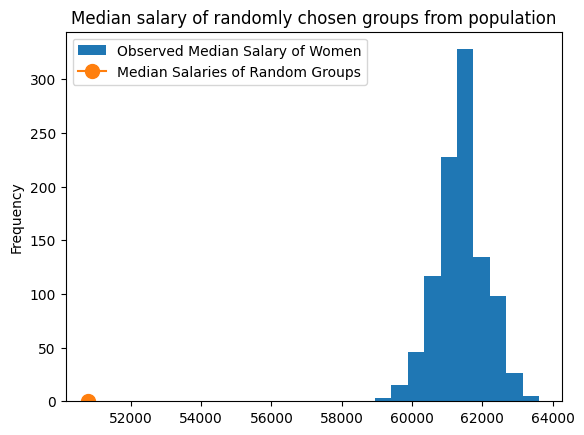

In [13]:
# size of sample is number of women:
n_female = (salaries_with_gender['gender'] == 'F').sum()


# calculate observed 
female_median = salaries_with_gender.loc[salaries_with_gender['gender'] == 'F']['Total Pay'].median()


# simulate 1000 draws from the population of size n_female
medians = []
for _ in np.arange(1000):
    median = salaries_with_gender.sample(n_female)['Total Pay'].median()
    medians.append(median)
    
    
title='Median salary of randomly chosen groups from population'
pd.Series(medians).plot(kind='hist', title=title);
plt.plot([female_median], [0], marker='o', markersize=10)
plt.legend(['Observed Median Salary of Women', 'Median Salaries of Random Groups']);


Now that the question of differences in the salaries of genders is answered, however there are still some more questions. 

First, are the results correct?
* Is the name-to-gender assignment correct (enough)?
* What biases might have been introduced when joining the dataset of names to salaries?
* Are the results applicable outside of 2017? outside of San Diego? 

Second, why are the results what they are?
* Is the disparity correlated to pay-type? job status? job type?
* What is the cause of the disparity?

The sections below approach each of these questions, giving a feel for what's involved in answering them.

### Is the name-to-gender assignment correct?

* How many names are borderline male/female?
* Does it make sense to incorporate name usage from all years in the dataset? (1880-2017?)

The plot below shows the distribution of 'proportions of names being female.' 
* The bar near 0 are counts of names that are almost entirely male. 
* The bar near 1 are counts of names that are almost entirely female. 
* There are very few names in the middle that are gender-neutral.

However, each unit plotted is a distinct name; the proportions hide the number of people with each name. What if the most popular name in the country is gender-neutral?

What's more appropriate is to look at this distribution of confidence among the dataset of employees.

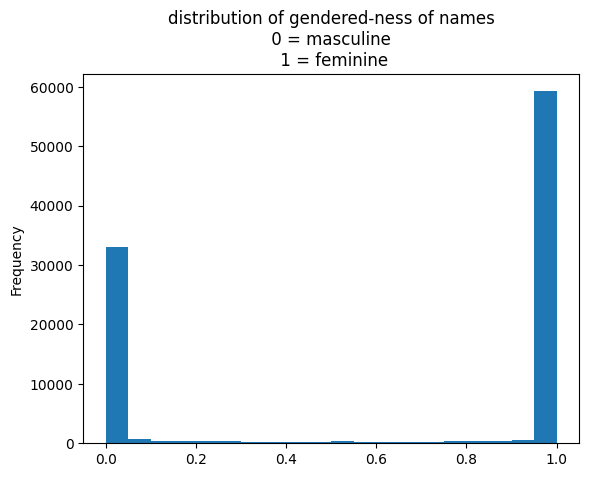

In [14]:
title = 'distribution of gendered-ness of names\n 0 = masculine \n 1 = feminine'
prop_female.plot(kind='hist', bins=20, title=title);

### Assessment of the join?

* Are there names in the salary dataset that aren't in the SSA dataset?
    - Who might not be in the SSA dataset? 
    - Might these names be biased toward certain salaries?
* Does the salary dataset have a disproportionately large portion of gender-neutral names.
* Is it better to use a subset of the SSA dataset (e.g. by state? by year?)
    - Do the gender of names typically vary by geography or over time?
    
The proportion of employees not in the SSA data is 3.5%, which is fairly small, but may affect the results. These individuals should be investigated more closely; a look at the employees with a gender assigned versus those that didn't appear in the SSA names dataset reveals some bias (see table below). 

Perhaps those that didn't appear in the names dataset have lower salaries because they belong to an uncommon ethnic group (e.g. an immigrant group)? Such populations would likely work in jobs that earn lower salaries. One could 
further clean up these missing genders by incorporating the demographic information from immigration data.


In [15]:
# proportion of employees not in SSA dataset
# salaries_with_gender['gender'].isnull().mean()

# Description of total pay by joined vs not joined
(
    salaries_with_gender
    .assign(joined=salaries_with_gender['gender'].notnull())
    .groupby('joined')['Total Pay']
    .describe()
    .T
)

joined,False,True
count,445.000000,12048.000000
mean,57033.523596,65278.662434
std,38261.845670,41910.973914
...,...,...
50%,55282.000000,61650.500000
75%,78970.000000,91895.000000
max,194920.000000,323377.000000


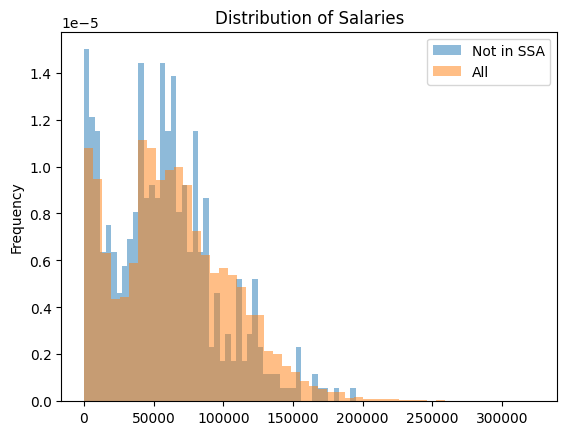

In [16]:
nonjoins = salaries_with_gender.loc[salaries_with_gender['gender'].isnull()]

title = 'Distribution of Salaries'
nonjoins['Total Pay'].plot(kind='hist', bins=50, alpha=0.5, density=True, sharex=True)
salaries_with_gender['Total Pay'].plot(kind='hist', bins=50, alpha=0.5, density=True, sharex=True, title=title)
plt.legend(['Not in SSA','All']);

### Why does pay disparity exist?

Is the pay disparity correlated to another field? job status? job type? Is the proportion of women in a job type correlated to pay? One approach might ask if women earn similar salaries as men for a given job type.

Below, a few job types are isolated for investigation. For example, those who work in 'Fire' related fields tend to be male and make high salaries:

In [17]:
# select jobs with word 'fire' in them
firejobs = salaries_with_gender.loc[salaries_with_gender['Job Title'].str.contains('Fire')]
firejobs.sample(5)

,Employee Name,Job Title,Total Pay,Status,firstname,proportion of a given name that's identified as female,gender
9839,Alan M Cummings,Fire Fighter 2,30470.0,PT,Alan,0.003077,M
5882,Marco A Romero Valdez,Fire Fighter 1,66152.0,PT,Marco,0.004758,M
2256,Dylan E Chiu,Fire Engineer,106768.0,FT,Dylan,0.033090,M
1288,Skip Reed,Fire Captain,112946.0,FT,Skip,0.000000,M
1422,David K Conde,Fire Captain,136443.0,PT,David,0.003552,M


The proportion of fire-related jobs held by women is only 8.8%, yet fire-related jobs make significantly more than the overall median pay of 61,000USD per year:

In [18]:
# Proportion of fire-related jobs held by women
#(firejobs['gender'] == 'F').mean()

# Pay Statistics for fire-related jobs
firejobs['Total Pay'].describe()

count      1017.000000
mean     110967.646018
std       49678.113970
             ...      
50%      112568.000000
75%      141502.000000
max      323377.000000
Name: Total Pay, Length: 8, dtype: float64

On the other hand, those with library-related jobs tend to be female and make lower-than-average salaries:

In [19]:
# select jobs with library related jobs
libjobs = salaries_with_gender.loc[salaries_with_gender['Job Title'].str.contains('Librar')]
libjobs.sample(5)

,Employee Name,Job Title,Total Pay,Status,firstname,proportion of a given name that's identified as female,gender
11795,Beatriz Rovira,Library Aide,5268.0,PT,Beatriz,0.996994,F
9965,Darryle Williams,Library Clerk,24326.0,PT,Darryle,0.000000,M
12181,Heolbare Reynoso,Library Aide,2467.0,PT,Heolbare,NaN,NaN
11811,Romulo P Belarmino,Library Aide,5124.0,PT,Romulo,0.000000,M
11653,Elissa R Livingstone,Library Aide,6393.0,PT,Elissa,1.000000,F


The proportion of library-related jobs held by women is 64%, yet library related jobs make significantly less than the overall median salary:

In [20]:
# Proportion of library-related jobs held by women
#(libjobs['gender'] == 'F').mean()

# Pay Statistics for fire-related jobs
libjobs['Total Pay'].describe()

count       651.000000
mean      30383.377880
std       23236.318495
             ...      
50%       26952.000000
75%       43566.000000
max      167269.000000
Name: Total Pay, Length: 8, dtype: float64

We see that there can be other factors for pay inequality as well like women working more in low paying jobs (i.e as a librarian) in our case while men working in high paying jobs (fireman), however it's not white and black and further analysis definately needs to be done for such complicated topics 